## Build network using pretrained MobileNet_V2 architecture for Self created Drone dataset

## Attempt-3: 
1. Preparing of dataset (Handling non-media files, erronous files, duplicate files.
2. Input images are of multiple resolution. 
Created 7 image size bins and applied convolution network to lear paramter to resize the dimension to 224X224
3. Applied Image augmnentation
4. Used Pre-Trained MobileNet_V2 network where last 3 layers is un-freezed and added own classifier layer



In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2


In [4]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [6]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.6"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.6


In [7]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [8]:
#import shutil
#shutil.rmtree('./logs_new')

In [9]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = "logs_v3_resize"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [10]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=1,
    num_workers=6,
    epochs=20,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False, 
    load_model_path = Path(f'./logs_v3_resize_v1/saved_models/ep1_testloss_1.322092000.pth'), # used when resume_training is True
    #load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [11]:
# dataset path where zip files are placed
src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/s2_dataset/'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s2_dataset'

In [12]:
import shutil
#shutil.rmtree(root_dataset)

In [13]:
class_list = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
class_list_shortname = ['FB', 'LQC', 'SQC', 'WD']

def display_classnames(shortname_list, fullname_list):
  for shortname, fullname in zip(shortname_list, fullname_list):
    print(f'{shortname}: {fullname}') 

# Preparing Dataset

In [14]:
import utils.data_utils as dutils

In [15]:
# Extracting zipped dataset into colab internal memory
%%time

# create root destination folder
if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

# extract individual class zip file
for classname in class_list:
  class_zipname = f'{src_dataset_dir}/{classname}.zip'
  class_dir = f'{root_dataset}/{classname}' # class folder unzip location
  if not Path(class_dir).exists():
    print(f'Extracting {classname} images...')
    dutils.extract_dataset(fn=class_zipname, dest=class_dir)

Extracting Flying Birds images...
Extracting Large QuadCopters images...
Extracting Small QuadCopters images...
Extracting Winged Drones images...
CPU times: user 29.9 s, sys: 7.65 s, total: 37.5 s
Wall time: 1min 43s


In [16]:
dutils.get_dataset_count(root_dataset, class_list)

Flying Birds: 8338 images
Large QuadCopters: 4169 images
Small QuadCopters: 3623 images
Winged Drones: 5675 images

Total images: 21805


# Remove all duplicate and errornous file

In [17]:
import pandas as pd
df_dataset = pd.read_csv('eda_duplicate_list.csv')
df_remove = df_dataset[(df_dataset['duplicate'] == 1) | (df_dataset['cross_duplicate'] == 1) | (df_dataset['errornous_file'] == 1)]
print(f'File to removes: {len(df_remove)}')
df_remove['classname'].value_counts()

File to removes: 2376


Winged Drones        1486
Flying Birds          407
Small QuadCopters     317
Large QuadCopters     166
Name: classname, dtype: int64

In [18]:
df_remove.head()

,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class
397,Flying Birds/fb_img_0430.jpg,Flying Birds,0,1,Flying Birds/flying-common-raven-picture-id117...,0,NaN
470,Flying Birds/animal-photography-bird-flying-50...,Flying Birds,0,1,Flying Birds/white-bird-50685.jpg,0,NaN
613,Flying Birds/Copy of 4d34f43aadc32f89c38c37493...,Flying Birds,0,1,Flying Birds/4d34f43aadc32f89c38c37493eed81170...,0,NaN
904,Flying Birds/ZHATuKpukACkWHz5ObmLRgHaEK.jpg,Flying Birds,0,1,Flying Birds/image132.jpg,0,NaN
958,Flying Birds/aFrDNzUEXrI.jpg,Flying Birds,0,1,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,0,NaN


In [19]:
from tqdm import tqdm
def remove_files(rootdir, df_data):
    dvalues = df_data.values
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      if Path(filepath).exists():
        os.remove(filepath)
      pbar.set_description(desc=f'Removing files..')
    return

In [20]:
remove_files(root_dataset, df_remove)

Removing files..: 100%|██████████| 2376/2376 [00:04<00:00, 571.75it/s]


In [21]:
# check the final dataset summary used for model building
dutils.get_dataset_count(root_dataset, class_list)

Flying Birds: 7931 images
Large QuadCopters: 4003 images
Small QuadCopters: 3306 images
Winged Drones: 4189 images

Total images: 19429


In [22]:
import pandas as pd
df_final = df_dataset[(df_dataset['duplicate'] == 0) & (df_dataset['cross_duplicate'] == 0) & (df_dataset['errornous_file'] == 0)]
print(f'Count: {len(df_final)}')
df_final['classname'].value_counts()

Count: 19429


Flying Birds         7931
Winged Drones        4189
Large QuadCopters    4003
Small QuadCopters    3306
Name: classname, dtype: int64

## Analysing Images Sizes and its distibution in Dataset

In [23]:
from tqdm import tqdm
from PIL import Image
df_final["width"] = 0 
df_final["height"] = 0 

pbar = tqdm(df_final.values)
for row in pbar:
    filepath = f'{root_dataset}/{row[0]}'
    img = Image.open(filepath)
    df_final.loc[df_final.filename == row[0], 'width'] = img.size[0]
    df_final.loc[df_final.filename == row[0], 'height'] = img.size[1]
    del img
    pbar.set_description(desc=f'Reading image sizes..')

Reading image sizes..: 100%|██████████| 19429/19429 [02:36<00:00, 124.27it/s]


In [25]:
df_final.head()

,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class,width,height
0,Flying Birds/photo-of-a-bird-2752878.jpg,Flying Birds,0,0,NaN,0,NaN,6000,4000
1,Flying Birds/low-angle-shot-two-birds-flying-c...,Flying Birds,0,0,NaN,0,NaN,224,224
2,Flying Birds/180px-African_fish_eagle_(Haliaee...,Flying Birds,0,0,NaN,0,NaN,180,120
3,Flying Birds/fb_nationalgeographic_1517960.jpg,Flying Birds,0,0,NaN,0,NaN,1200,630
4,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,Flying Birds,0,0,NaN,0,NaN,3648,2736


## Image size Histogram distribution

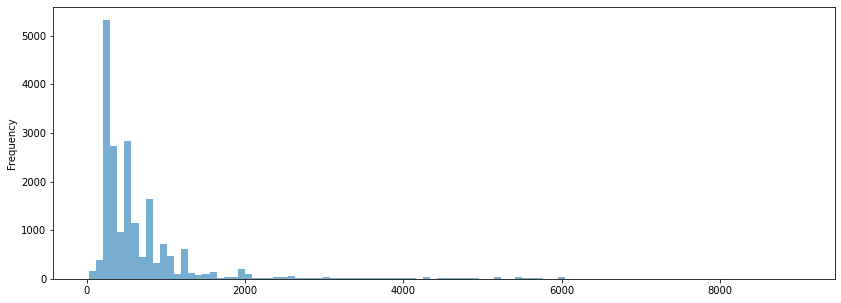

In [26]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
df_final["width"].plot.hist(bins=100, alpha=0.6, ax=axs)

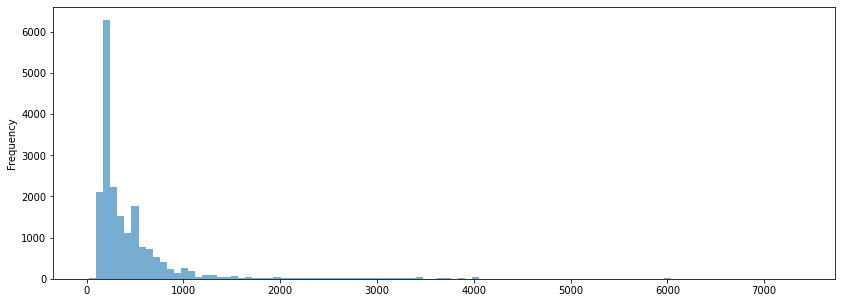

In [27]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
df_final["height"].plot.hist(bins=100, alpha=0.6, ax=axs)

Image of size less than 224: 1051


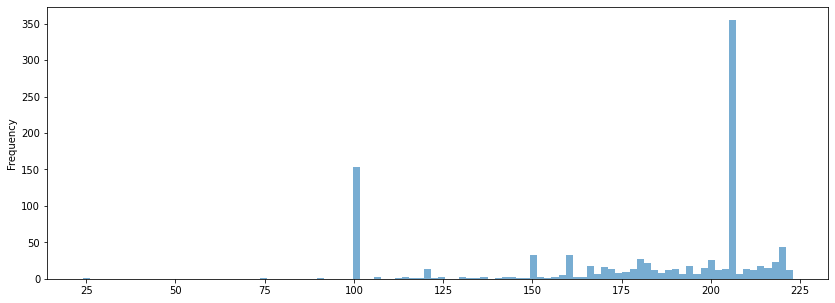

In [28]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
df_final[df_final["width"] < 224]["width"].plot.hist(bins=100, alpha=0.6, ax=axs)

print(f'Image of size less than 224: {len(df_final[df_final["width"] < 224])}')

# Prepare Data Transforms and DataLoader

In [29]:
from PIL import Image
from torchvision import transforms

'''
1. MobileNet_V2 network expect input image size of (224,224).. so create bin of multiple of 224 image sizes
2. Seven Bins are created for images sizes fo following size: 224, 448, 672, 896, 1344, 1792, 2688, 3584
3. Resizing CNN network will learn the parameter to resize the images to 224X224 for mobilenet_v2 network
'''
class RescaleBins():
  def __init__(self):
      self.default_size = 224
  def __call__(self, img):
      #print(f'type: type{img}, {img.size[0]}')
      outsize = self.default_size
      insize = img.size[0]
      if (insize <= (224 + 112)):
          outsize = 224
      elif (insize > (224 + 112) and insize <= (448+112)):
        outsize = 448
      elif (insize > (448 + 112) and insize <= (672+112)):
        outsize = 672
      elif (insize > (672+112) and insize <= (896+224)):
        outsize = 896
      elif (insize > (896+224) and insize <= (1344+224)):
        outsize = 1344
      elif (insize > (1354+224) and insize <= (1792+448)):
        outsize = 1792
      elif (insize > (1792+448) and insize <= (2688+448)):
        outsize = 2688
      elif (insize > (2688+448)):
        outsize = 3584

      img = img.resize((outsize,outsize), Image.NEAREST)
      return img

class ResizingImgAugmentation():
      def __init__(self, means, stds):
          self.means =means
          self.stds = stds

      # Transform functions
      def get_train_transform(self):
          fill_value = [int(255. * mean) for mean in self.means]

          train_tf = transforms.Compose([
                RescaleBins(),
                transforms.ColorJitter(brightness=0.10, contrast=0.10),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(self.means, self.stds),
                transforms.RandomErasing(scale=(0.02, 0.15), ratio=(0.8, 1.2))                       
          ])
          return train_tf

      def get_test_transform(self):
          test_tf = transforms.Compose([
                RescaleBins(),
                transforms.ToTensor(),
                transforms.Normalize(self.means, self.stds)                
          ])
          return test_tf

In [30]:
from utils.ImageAugmentationUtils import AlbumImageAugmentation
from utils.ImageAugmentationUtils import PyTorchImageAugmentation

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

#imgAugmentation = AlbumImageAugmentation(means, stds, size=224)
#imgAugmentation = PyTorchImageAugmentation(means, stds, size=224)
imgAugmentation = ResizingImgAugmentation(means, stds)

train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [31]:
dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

train_loader, test_loader = dutils.prepare_dataloader(datadir=root_dataset, 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args, 
                                               valid_size=0.30)

print(f'Classes: {train_loader.dataset.classes}')


Total data: 19429

Training size: 13601
Testing size: 5828
Classes: ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# Visualize few training images

In [32]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_list_shortname, means, stds)

FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


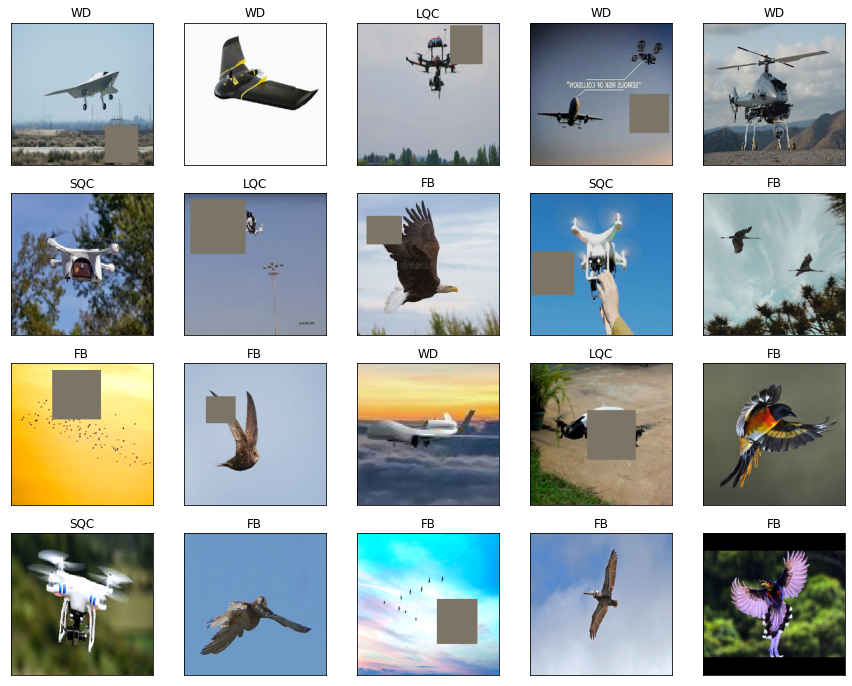

In [19]:
# visualize how image aumentation is applied on few training dataset images: 
display_classnames(class_list_shortname, class_list)
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [20]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Image size: torch.Size([3, 896, 896])


# Pretrained MobileNet_V2 network

In [33]:
# Common utility fxn for freezing the layer

def freeze_all_layers(model):
    for name, layer in model.named_modules():
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_name(model, unfreeze_layer_name_list):
    for name, layer in model.named_modules():
      unfreeze = any(n in name for n in unfreeze_layer_name_list)
      if(unfreeze):
        for parameter in layer.parameters():
          parameter.requires_grad = True
      else:
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_ids(model, unfreeze_layer_ids_list):
    # MobileNet_V2 have 19 features block accessible throunf name: features[idx]
    for idx in range(19):
      if idx in unfreeze_layer_ids_list:
        for param in model.features[idx].parameters():
          param.requires_grad = True
      else:
        for param in model.features[idx].parameters():
          param.requires_grad = False

def show_layers(model):
    for name, layer in model.named_modules():
      for parameter in layer.parameters():
        print(f'Layer name: {name}, Requires Grad: {parameter.requires_grad}')

In [22]:
# load pre-training model
from torchvision.models import mobilenet_v2
pretrained_model = mobilenet_v2(pretrained=True)

In [23]:
# unfreeze last three block and make all remaining layers as non-trainable
unfreeze_layer_names = ['features.17', 'features.18', 'classifier']
unfreeze_layers_by_name(pretrained_model, unfreeze_layer_names)

In [24]:
#show_layers(pretrained_model)

In [25]:
#unfreeze_layers_idx = [16, 17, 18]
#unfreeze_selective_layers_by_ids(model, unfreeze_layers_idx )

In [26]:
# adding own FC and classification layer.. these layer will be trained 
pretrained_model.classifier = nn.Sequential(nn.Dropout(0.2),
                                 nn.Linear(1280, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1024),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))

In [27]:
from torchsummary import summary
from models.DroneNetwork import DroneNetwork
model_name = "MobileNet_V2"
model = DroneNetwork(pretrained_model)
model = model.to(device)
summary(model, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ResizingConvNetwork-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
             ReLU6-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 16, 112, 112]             512
       BatchNorm2d-9         [-1, 16, 112, 112]              32
 InvertedResidual-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 96, 112, 112]           1,536
      BatchNorm2d-12         [-1, 96, 112, 112]             192
            ReLU6-13         [-1, 96, 112, 112]               0
           Conv2d-14           [-1, 96

## LR Finder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=400, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


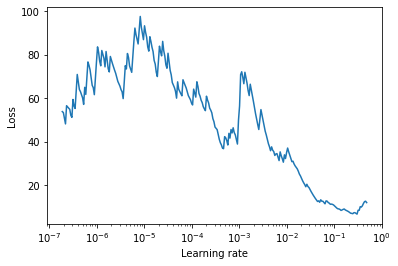

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [ ]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

## Build and train model

In [28]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 1e-3   # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 8 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=min_lr, momemtum=0.9, nesterov=True, weight_decay=L2_val) 
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)  

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)


In [29]:
import utils.model_utils as mutils_fxn

# if resuming the traning then load the model, update optimizer states and loss state
if config_params["resume_training"] == True:
  print("This is resuming the training session...")
  model, optimizer, start_epoch, criterion = mutils_fxn.load_checkpoint(model, optimizer, device, config_params["load_model_path"])
else:
  print("This is fresh attempt training ...")

This is fresh attempt training ...


In [30]:
if config_params["resume_training"] == True:
  for param in model.resizingNet.parameters():
    param.requires_grad = False

In [31]:
from utils.model_utils import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=reduceLr_scheduler,
                    saved_model_dir=SAVED_MODELS_DIR,
                    tqdm_status=True)

In [ ]:
m_history = mutils.build()

  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 1 TRAIN ==> [Batch=13601] train_loss=1.328870 train_acc: 40.72 LR=0.001000000: 100%|██████████| 13601/13601 [14:12<00:00, 15.96it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 1 TEST  ==> [Batch=5828] test_loss=1.325287 test_acc: 40.82: 100%|██████████| 5828/5828 [03:43<00:00, 26.07it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 2 TRAIN ==> [Batch=13601] train_loss=1.345049 train_acc: 39.61 LR=0.013375000: 100%|██████████| 13601/13601 [14:21<00:00, 15.79it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 2 TEST  ==> [Batch=5828] test_loss=1.336039 test_acc: 40.82: 100%|██████████| 5828/5828 [03:45<00:00, 25.89it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 3 TRAIN ==> [Batch=13601] train_loss=1.361080 train_acc: 38.60 LR=0.025750000: 100%|██████████| 13601/13601 [14:13<00:00, 15.94it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 3 TEST  ==> [Batch=5828] test_loss=1.377803 test_acc: 16.75: 100%|██████████| 5828/5828 [03:44<00:00, 25.96it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 4 TRAIN ==> [Batch=13601] train_loss=1.373451 train_acc: 37.01 LR=0.038125000: 100%|██████████| 13601/13601 [14:16<00:00, 15.88it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 4 TEST  ==> [Batch=5828] test_loss=1.375919 test_acc: 40.82: 100%|██████████| 5828/5828 [03:45<00:00, 25.82it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 5 TRAIN ==> [Batch=13601] train_loss=1.383732 train_acc: 36.39 LR=0.050500000: 100%|██████████| 13601/13601 [14:28<00:00, 15.66it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 5 TEST  ==> [Batch=5828] test_loss=1.343269 test_acc: 40.82: 100%|██████████| 5828/5828 [03:44<00:00, 25.98it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 6 TRAIN ==> [Batch=13601] train_loss=1.392281 train_acc: 36.21 LR=0.062875000: 100%|██████████| 13601/13601 [14:29<00:00, 15.65it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 6 TEST  ==> [Batch=5828] test_loss=1.328744 test_acc: 40.82: 100%|██████████| 5828/5828 [03:47<00:00, 25.65it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 7 TRAIN ==> [Batch=13601] train_loss=1.330919 train_acc: 40.78 LR=0.007525000: 100%|██████████| 13601/13601 [14:29<00:00, 15.64it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 7 TEST  ==> [Batch=5828] test_loss=1.328225 test_acc: 40.82: 100%|██████████| 5828/5828 [03:46<00:00, 25.68it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 8 TRAIN ==> [Batch=13601] train_loss=1.403317 train_acc: 35.12 LR=0.087625000: 100%|██████████| 13601/13601 [14:40<00:00, 15.44it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 8 TEST  ==> [Batch=5828] test_loss=1.457605 test_acc: 40.82: 100%|██████████| 5828/5828 [03:48<00:00, 25.46it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 9 TRAIN ==> [Batch=13601] train_loss=1.411086 train_acc: 34.86 LR=0.100000000: 100%|██████████| 13601/13601 [14:30<00:00, 15.62it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 9 TEST  ==> [Batch=5828] test_loss=1.399604 test_acc: 21.98: 100%|██████████| 5828/5828 [03:49<00:00, 25.43it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 10 TRAIN ==> [Batch=13601] train_loss=1.402360 train_acc: 35.09 LR=0.087625000: 100%|██████████| 13601/13601 [14:38<00:00, 15.49it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 10 TEST  ==> [Batch=5828] test_loss=1.543078 test_acc: 40.82: 100%|██████████| 5828/5828 [03:47<00:00, 25.57it/s]
  0%|          | 0/13601 [00:00<?, ?it/s]

Epoch: 11 TRAIN ==> [Batch=13601] train_loss=1.398335 train_acc: 35.50 LR=0.075250000: 100%|██████████| 13601/13601 [14:42<00:00, 15.41it/s]
  0%|          | 0/5828 [00:00<?, ?it/s]
Epoch: 11 TEST  ==> [Batch=1693] test_loss=1.470001 test_acc: 40.22:  29%|██▉       | 1692/5828 [01:07<03:05, 22.30it/s]

In [ ]:
m_history.result_summary()

In [34]:
best_model = torch.load(f'{SAVED_MODELS_DIR}/bestmodel.pt')

In [35]:
import utils.model_utils as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(best_model, device, test_loader)
print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

Accuracy of the model on the 5828 test images: 40.61%


In [37]:
#mutils_fxn.get_class_based_accuracy(best_model, device, test_loader, class_list)

In [39]:
# Accurracy and loss history plot
#m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')

# Visualize few misclassified images

Ploting misclassified images:

Abbrevation used: 
T: Target, P: Prediction
FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


Misclassification for Flying Birds..
Misclassification for Large QuadCopters..
Misclassification for Small QuadCopters..
Misclassification for Winged Drones..
CPU times: user 1min 30s, sys: 13.9 s, total: 1min 44s
Wall time: 3min 38s


<Figure size 2160x216 with 0 Axes>

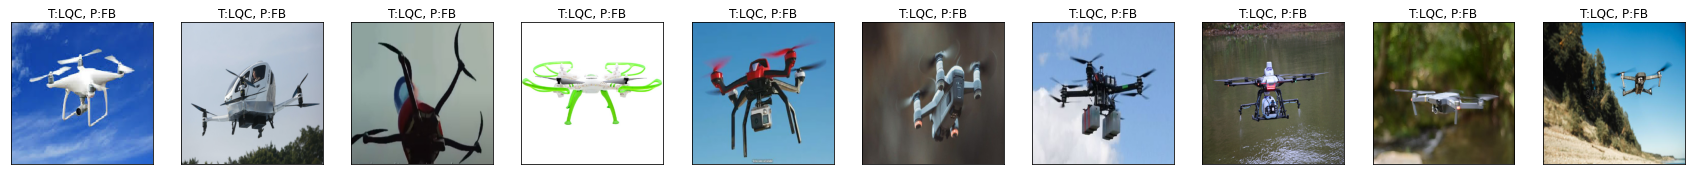

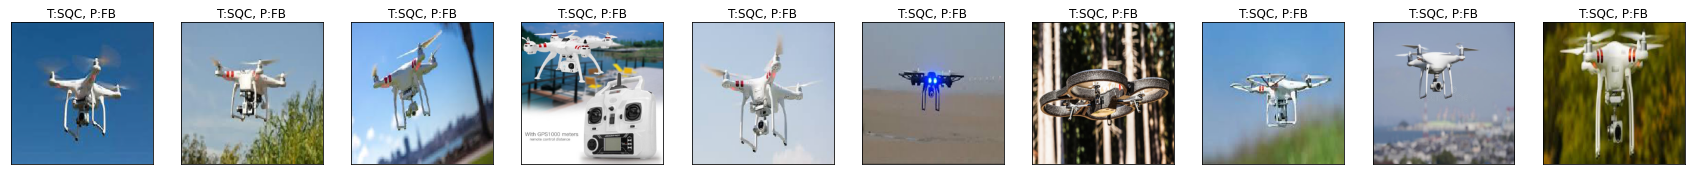

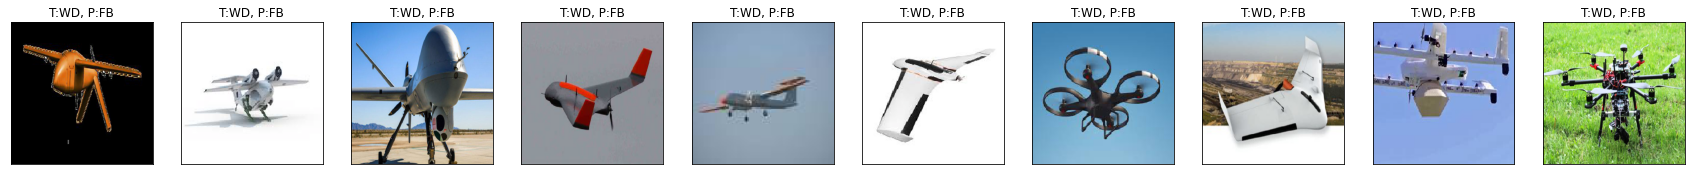

In [40]:
%%time
print('Ploting misclassified images:\n')

print('Abbrevation used: \nT: Target, P: Prediction')
display_classnames(class_list_shortname, class_list)
print('\n')
for idx, name in enumerate(class_list):
  print(f'Misclassification for {name}..')
  putils.plot_misclassified_images_for_class(best_model, 
                                             testloader=test_loader, 
                                              classid=idx,
                                              figsize=(30,3),
                                              num_of_images=10, nrow=1, 
                                              save_filename=f'{PLOT_DIR}/{name}_misclassified_images.jpg')